In [1]:
# Import STRAVA data
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import utm
import matplotlib.tri as tri
# Find nearest index value in numpy array
def find_nearest_index(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

# Import Strava data
beach_name = 'IB'
df_path = '/results/'+beach_name+'StravaXYZ.csv'
print(df_path)
# load dataframe
Sdf = pd.read_csv(os.getcwd() + df_path)
# convert to datetime
Sdf['time'] = pd.to_datetime(Sdf['time'])

# retrieve data
xS = Sdf['X'].values
yS = Sdf['Y'].values
zS = Sdf['Z'].values
%matplotlib inline
Sdf.head()

/results/IBStravaXYZ.csv


,time,X,Y,lat,lon,Z
0,2016-06-24 18:20:58,487557.342735,3.605725e+06,32.588933,-117.132585,1.591521
1,2016-06-24 18:20:59,487557.152140,3.605723e+06,32.588912,-117.132587,1.591521
2,2016-06-24 18:21:00,487557.148962,3.605720e+06,32.588889,-117.132587,1.591521
3,2016-06-24 18:21:01,487557.052214,3.605718e+06,32.588868,-117.132588,1.591521
4,2016-06-24 18:21:02,487557.049312,3.605716e+06,32.588847,-117.132588,1.591521


In [2]:
# Import Lidar data (bias corrected)
beach_name = 'IB'
df_path = '/results/'+beach_name+'_Lerrorbias_v2.csv'
print(df_path)
# load dataframe
Ldf = pd.read_csv(os.getcwd() + df_path)
del Ldf['Unnamed: 0']

# retrieve data
xL = Ldf['x'].values
yL = Ldf['y'].values
# zL = Ldf['z'].values + Ldf['z_bias'].values[0]
zL = Ldf['z'].values
dzcstd = Ldf['z_2sigma'].values[0]
Ldf.head()


/results/IB_Lerrorbias_v2.csv


,x,y,z,z_2sigma,z_bias
0,487404.183561,3.605836e+06,0.01610,0.888414,0
1,487404.683600,3.605836e+06,0.01459,0.888414,0
2,487405.183639,3.605836e+06,0.00319,0.888414,0
3,487405.683677,3.605836e+06,-0.00375,0.888414,0
4,487406.183716,3.605836e+06,-0.00436,0.888414,0


In [3]:
# Concatenate Strava data with Lidar data
xSL = np.append(xS,xL)
ySL = np.append(yS,yL)
zSL = np.append(zS,zL)

print(len(yS))
print(len(yL))
len(ySL)

51832
2212505


2264337

In [4]:
# Locations to be examined
PalmAve_latlon = [32.583944, -117.132697] # Palm Ave
IBAve_latlon = [32.576617, -117.132387] # Imperial Beach Ave
SCDr_latlon = [32.566384,-117.132700] # South Seacoast Drive
CortezAve_latlon = [32.572645, -117.132500] # Cortez Ave
EncantoAve_latlon = [32.569375, -117.132761] # Encanto Ave
DescansoAve_latlon = [32.571174,-117.132643] # Descanso Ave
# CarnationAve_latlon = [32.585677, -117.132441] # Carnation Ave 
loc_names_list = ["PalmAve","IBAve","SCDr",
                  "CortezAve","EncantoAve",
                  "DescansoAve"]
latlon_list = [PalmAve_latlon,IBAve_latlon,SCDr_latlon,
               CortezAve_latlon,EncantoAve_latlon,
               DescansoAve_latlon]
# Threshold levels: https://climateadapt.ucsd.edu/imperialbeach/forecast/
zTWL = [2.9,3.2,3.2,3.2,3.2,3.2]

# Create grid values first.
nresy = 1/0.25
nresx = 1/0.25
print("x grid resolution is {} m.".format(1/nresx))
print("y grid resolution is {} m.".format(1/nresy))

# Convert lat,lon to x,y
z_diff=[]
z_inf=[]
z_patch=[]
cc = -1
for Loc_latlon,Loc_name in zip(latlon_list,loc_names_list):
    cc+=1
    Loc_xy = utm.from_latlon(Loc_latlon[0], Loc_latlon[1])
    # Find z
    di = np.sqrt((xSL-Loc_xy[0])**2 + (ySL-Loc_xy[1])**2)
    ii = find_nearest_index(di,0)
    z_diff.append(zL[ii]-zTWL[cc])
    z_inf.append(zL[ii])
    # Exceptions:
    # Create patch around location (remove Lidar data and replace with Threshold values)
    xmax = Loc_xy[0]+0
    xmin = Loc_xy[0]-30
    ymax = Loc_xy[1]+20
    ymin = Loc_xy[1]-20
    ngridx = round((xmax-xmin)*nresx)
    ngridy = round((ymax-ymin)*nresy)
    xTWL = np.linspace(xmin, xmax, ngridx)
    yTWL = np.linspace(ymin, ymax, ngridy)
    XTWL, YTWL = np.meshgrid(xTWL, yTWL)
    XTWL = np.array(XTWL).flatten()
    YTWL = np.array(YTWL).flatten()
    for x,y in zip(XTWL,YTWL):
        d = np.sqrt((x-xSL)**2 + (y-ySL)**2)
        kk = find_nearest_index(d,0)
        # Replace if it exceeds the threshold value        
        if zSL[kk]>zTWL[cc]:
            zSL[kk] = zTWL[cc]
    print(loc_names_list[cc] + ': done!')
    # Create dictionary    
    if cc==0:
        xyL_dic = {Loc_name:Loc_xy}
        zL_dic = {Loc_name:zL[ii]}
        zTWL_dic = {Loc_name:zTWL[cc]}
    else:
        xyL_dic.update({Loc_name:Loc_xy})
        zL_dic.update({Loc_name:zL[ii]})
        zTWL_dic.update({Loc_name:zTWL[cc]})


# tt_flmx
# zL_dic
# zTWL_dic
np.nanmedian(z_diff)
xyL_dic


x grid resolution is 0.25 m.
y grid resolution is 0.25 m.


/Users/andre/anaconda3/envs/bluetribe/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/andre/anaconda3/envs/bluetribe/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


PalmAve: done!
IBAve: done!
SCDr: done!
CortezAve: done!
EncantoAve: done!
DescansoAve: done!


{'PalmAve': (487546.142071085, 3605172.2385763368, 11, 'S'),
 'IBAve': (487574.2255939384, 3604359.984004461, 11, 'S'),
 'SCDr': (487543.43318234687, 3603225.6656681234, 11, 'S'),
 'CortezAve': (487563.07124795066, 3603919.6903540413, 11, 'S'),
 'EncantoAve': (487538.1206554272, 3603557.2328237677, 11, 'S'),
 'DescansoAve': (487549.44550910173, 3603756.64285001, 11, 'S')}

In [31]:
# Create additional patch
# plt.plot(487546+25, 3605172+25,'or',ms=8)
xSLp = xSL
ySLp = ySL
zSLp = zSL

# Create grid values first.
nresy = 1/0.25
nresx = 1/0.25
print("x grid resolution is {} m.".format(1/nresx))
print("y grid resolution is {} m.".format(1/nresy))

Loc_xy = [487546+25, 3605172+25]
# Loc_xy = utm.from_latlon(Loc_latlon[0], Loc_latlon[1])
# Create patch around location (remove Lidar data and replace with Threshold values)
xmax = Loc_xy[0]+15
xmin = Loc_xy[0]-5
ymax = Loc_xy[1]+40
ymin = Loc_xy[1]-40
ngridx = round((xmax-xmin)*nresx)
ngridy = round((ymax-ymin)*nresy)
xTWL = np.linspace(xmin, xmax, ngridx)
yTWL = np.linspace(ymin, ymax, ngridy)
XTWL, YTWL = np.meshgrid(xTWL, yTWL)
XTWL = np.array(XTWL).flatten()
YTWL = np.array(YTWL).flatten()
for x,y in zip(XTWL,YTWL):
    d = np.sqrt((x-xSLp)**2 + (y-ySLp)**2)
    kk = find_nearest_index(d,0)
    # Replace if it falls below the threshold value        
    if zSLp[kk]<3.5:
        zSLp[kk]=3.52
        
        


x grid resolution is 0.25 m.
y grid resolution is 0.25 m.


In [32]:
# x = xSL
# y = ySL
# z = zSL
x = xSLp
y = ySLp
z = zSLp


# -----------------------
# Interpolation on a grid
# -----------------------
# A contour plot of irregularly spaced data coordinates
# via interpolation on a grid.

# Create grid values first.
nresy = 1/5
nresx = 1/2
print("x grid resolution is {} m.".format(1/nresx))
print("y grid resolution is {} m.".format(1/nresy))

ngridx = round(x.max()-x.min())*nresx
ngridy = round(y.max()-y.min())*nresy
xi = np.linspace(x.min(), x.max(), ngridx)
yi = np.linspace(y.min(), y.max(), ngridy)

# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
# The following would be an alternative to the four lines above:
#from scipy.interpolate import griddata
#zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')



x grid resolution is 2.0 m.
y grid resolution is 5.0 m.


/Users/andre/anaconda3/envs/bluetribe/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/andre/anaconda3/envs/bluetribe/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


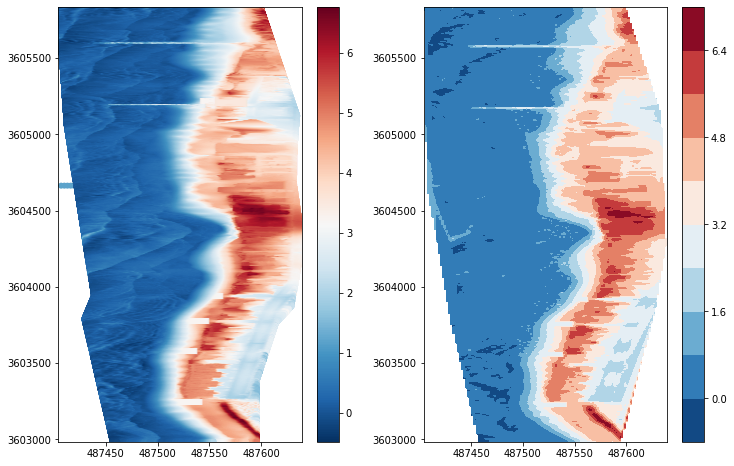

In [33]:
#Plot data 
fig = plt.figure(figsize = (12, 8))

ax1 = fig.add_subplot(121)
cntr1 = ax1.scatter(xSLp,ySLp, c=zSLp, linewidths=0, cmap="RdBu_r")
# cntr1 = ax1.scatter(xL,yL, c=zL, linewidths=0, cmap="RdBu_r")
# cntr0 = ax1.scatter(xS,yS, c=zS, linewidths=0, cmap="RdBu_r")
# plt.gca().set_aspect('equal', adjustable='box')
fig.colorbar(cntr1, ax=ax1)

ax2 = fig.add_subplot(122, sharex=ax1, sharey=ax1)
cntr2 = ax2.contourf(xi, yi, zi, levels=8, cmap="RdBu_r")
# plt.gca().set_aspect('equal', adjustable='box')
fig.colorbar(cntr2, ax=ax2)


/Users/andre/anaconda3/envs/bluetribe/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


(487450, 487650)

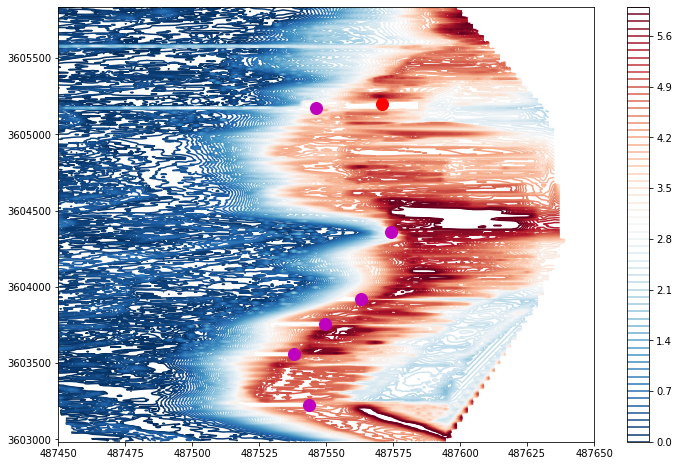

In [34]:
zmin = 0.0
zmax = 6.0
dz = 0.1
nz = (zmax-zmin)*1/dz+1
zlev = np.linspace(zmin,zmax,nz)

fig = plt.figure(figsize = (12, 8))

ax2 = fig.add_subplot(111)
cntr2 = ax2.contour(xi, yi, zi, levels=zlev, cmap="RdBu_r")
for key, value in xyL_dic.items():
    plt.plot(value[0],value[1],'om',ms=12)
plt.plot(Loc_xy[0],Loc_xy[1],'or',ms=12)
# cntr3 = ax2.contour(xi, yi, zi, levels=[3.5,3.75,4], cmap="jet")
# plt.gca().set_aspect('equal', adjustable='box')
fig.colorbar(cntr2, ax=ax2)
plt.xlim(487450,487650)

In [16]:
xyL_dic

{'PalmAve': (487546.142071085, 3605172.2385763368, 11, 'S'),
 'IBAve': (487574.2255939384, 3604359.984004461, 11, 'S'),
 'SCDr': (487543.43318234687, 3603225.6656681234, 11, 'S'),
 'CortezAve': (487563.07124795066, 3603919.6903540413, 11, 'S'),
 'EncantoAve': (487538.1206554272, 3603557.2328237677, 11, 'S'),
 'DescansoAve': (487549.44550910173, 3603756.64285001, 11, 'S')}

3.2

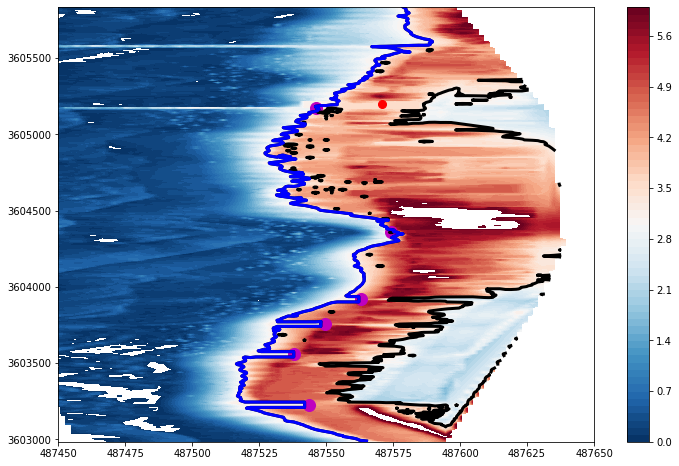

In [38]:
# Extract and clean contours

fig = plt.figure(figsize = (12, 8))
ax2 = fig.add_subplot(111)
cntr2f = ax2.contourf(xi, yi, zi, levels=zlev, cmap="RdBu_r")
for key, value in xyL_dic.items():
    plt.plot(value[0],value[1],'om',ms=12)
    
plt.plot(487546+25, 3605172+25,'or',ms=8)

fig.colorbar(cntr2f, ax=ax2)
plt.xlim(487450,487650)

jj = 32
xc = []
yc = []
lenc = []
for p in cntr2.collections[jj].get_paths():
    v = p.vertices
    x = v[:,0]
    y = v[:,1]
    plt.plot(x,y,'k',linewidth = 3)
    xc.append(x)
    yc.append(y)
    lenc.append(len(x))

ii = np.array(lenc).argmax()
plt.plot(xc[ii],yc[ii],'b',linewidth = 3) 

# plt.gca().set_aspect('equal', adjustable='box')

# for kk in np.where(np.array(lenc)>10)[0]:
#     print(kk)
#     plt.plot(xc[kk],yc[kk],'b',linewidth = 3)

cntr2.levels[jj]


In [39]:
for key, value in xyL_dic.items():
    print(value[0])
# for ii in xyL_dic:
#     print(ii)

487546.142071085
487574.2255939384
487543.43318234687
487563.07124795066
487538.1206554272
487549.44550910173


0.5
1.0
1.5
2.0
2.5
3.0
3.5
3.2


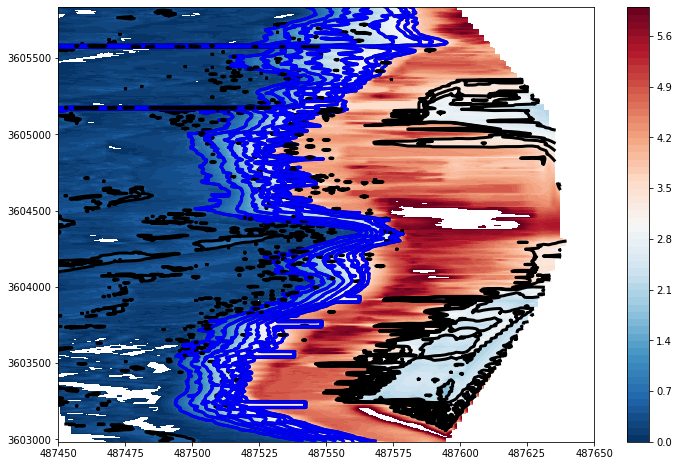

In [278]:
# Extract and clean contours 1

fig = plt.figure(figsize = (12, 8))
ax2 = fig.add_subplot(111)
cntr2f = ax2.contourf(xi, yi, zi, levels=zlev, cmap="RdBu_r")
fig.colorbar(cntr2f, ax=ax2)
plt.xlim(487450,487650)

xc = []
yc = []
zc = []
yLmin=[]
yLmax=[]
for jj in range(5,36,5):
    xcc = []
    ycc = []
    lenc = []
    for p in cntr2.collections[jj].get_paths():
        v = p.vertices
        x = v[:,0]
        y = v[:,1]
        plt.plot(x,y,'k',linewidth = 3)
        xcc.append(x)
        ycc.append(y)
        lenc.append(len(x))

    ii = np.array(lenc).argmax()
    plt.plot(xcc[ii],ycc[ii],'b',linewidth = 3) 
    xc.append(xcc[ii])
    yc.append(ycc[ii])
    zc.append(zlev[jj])
    print(zlev[jj])
    # Get min/max limits
    yLmin.append(ycc[ii].min())
    yLmax.append(ycc[ii].max())


jj= 32
xcc = []
ycc = []
lenc = []
for p in cntr2.collections[jj].get_paths():
    v = p.vertices
    x = v[:,0]
    y = v[:,1]
    plt.plot(x,y,'k',linewidth = 3)
    xcc.append(x)
    ycc.append(y)
    lenc.append(len(x))

ii = np.array(lenc).argmax()
plt.plot(xcc[ii],ycc[ii],'b',linewidth = 3) 
xc.append(xcc[ii])
yc.append(ycc[ii])
zc.append(zlev[jj])
print(zlev[jj])
# Get min/max limits
yLmin.append(ycc[ii].min())
yLmax.append(ycc[ii].max())


# Re-sort
I = sorted(range(len(zc)), key=lambda k: zc[k])
xc1 = xc
yc1 = yc
zc1 = zc
yLmin1=yLmin
yLmax1=yLmax
xc = []
yc = []
zc = []
yLmin=[]
yLmax=[]
for ii in I:
    xc.append(xc1[ii])
    yc.append(yc1[ii])
    zc.append(zc1[ii])
    yLmin.append(yLmin1[ii])
    yLmax.append(yLmax1[ii])

In [279]:
zc
    
    

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.2, 3.5]

In [280]:
# save contours data 

sav=1
if sav:
    np.savez('results/inter_contours/mat.npz', xc=xc, yc=yc)
else:
    # Load contour data
    data = np.load('results/inter_contours/mat.npz',allow_pickle=True)
    print(len(data['xc'][0]))
    print(len(data['yc'][0]))



len(xc)
zc

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.2, 3.5]

In [281]:
print(len(xc))
print(len(yc))
print(len(zc))

8
8
8


In [282]:
def knotstring(kt_list):
    '''
    This function does xxx and returns yyy
    '''
    kt_string = str(kt_list[0])
    for i in kt_list[1:]:
        kt_string = kt_string + ',' + str(i)
    return kt_string


def CurrFilt(v,nf,ny,ford,btype):
    """
    filters data using set parameters.

    Parameters
    ----------
    v : array_like
        input signal
    nf : float
        filter cuttoff (units of time)
    ny : float
        Nyquist period (units of time)
    ford : int
        filter order
    btype : {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}, optional
        The type of filter. Default is ‘lowpass’.
        
    Returns
    -------
    vf : array_like
        filtered signal
    """
    from scipy import signal
    nynf = ny/nf
    b, a = signal.butter(ford, nynf, btype=btype)
    vf = signal.filtfilt(b, a, v)

    return vf

# len(yp)/(ycpr.max()-ycpr.min())

Number of knots: 567
RMS for modified knot solution 1.1357954178406668


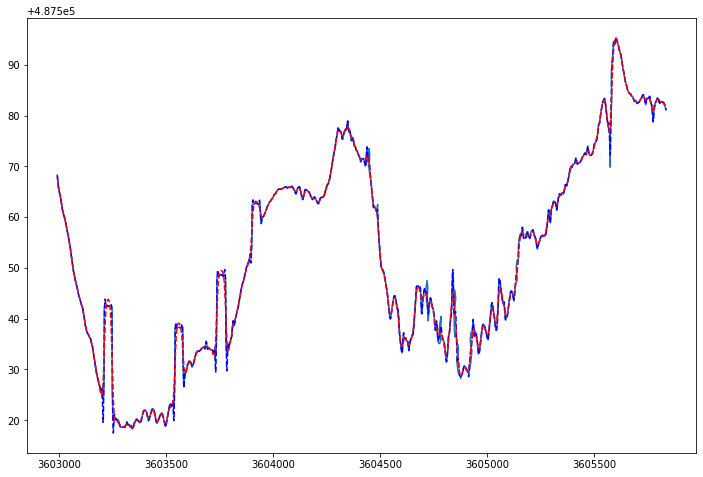

In [283]:
from sklearn.model_selection import train_test_split
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error 

# Generating cubic spline
deof = str(3)
# Length between knots (m)
dyc = 1/nresy
Lkt = dyc*1

# Interpolate using Cubic spline
# xcpr = xc[15]
# ycpr = yc[15]
# xcpr = xc[0]
# ycpr = yc[0]
xcpr = xc[-1]
ycpr = yc[-1]
# xcpr = xc[-30]
# ycpr = yc[-30]


yp = np.arange(ycpr.min(), ycpr.max(), nresy)


data_x = xcpr
data_y = ycpr

# Dividing data into train and validation datasets
train_y, valid_y, train_x, valid_x = train_test_split(data_x, data_y, test_size=0.33, random_state = 1)
    
# Define spline knots
# Number of knots (every Lkt m)
Nkt = int((data_y.max()-data_y.min())/Lkt)
kt = np.linspace(data_y.min(),data_y.max(),Nkt)
kt = kt[1:-1]

# convert knots from list to string
kt_str = knotstring(kt)
print("Number of knots: {}".format(Nkt-2))

# Bin average the data in space using Regression splines (x, y): cubic spline
# Generating cubic spline with X knots
transformed_y = dmatrix("bs(train, knots=("+kt_str+"),degree ="+ deof+", include_intercept=False)", {"train": data_y}, return_type='dataframe')
# # Fitting Generalised linear model on transformed dataset
fit = sm.GLM(data_x, transformed_y).fit()
# Predictions on splines
pred = fit.predict(dmatrix("bs(valid, knots=("+kt_str+"),degree ="+ deof+", include_intercept=False)", {"valid": data_y}, return_type='dataframe'))
# Calculating RMSE values
rmse = np.sqrt(mean_squared_error(data_x, pred))
print("RMS for modified knot solution {}".format(rmse))
# Make some predictions using splines
xp = fit.predict(dmatrix("bs(xp, knots=("+kt_str+"),degree ="+ deof+", include_intercept=False)", {"xp": yp}, return_type='dataframe'))

# filter output
nf = Lkt*40
ny = dyc/2
ford = 2
btype = 'lowpass'
xpf = CurrFilt(xp,nf,ny,ford,btype='lowpass')


fig = plt.figure(figsize = (12, 8))
plt.plot(ycpr,xcpr)
plt.plot(yp,xp,'--b')
plt.plot(yp,xpf,'--r')



In [284]:
from sklearn.model_selection import train_test_split
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error 

# Generating cubic spline
deof = str(3)
# Length between knots (m)
dyc = 1/nresy
Lkt = dyc*1

# Interpolate using Cubic spline, then low-pass filter
ycS=[]
xcS=[]
ycF=[]
xcF=[]
yp = np.arange(np.median(yLmin), np.median(yLmax), nresy)
for data_x,data_y in zip(xc,yc):
    # Dividing data into train and validation datasets
    train_y, valid_y, train_x, valid_x = train_test_split(data_x, data_y, test_size=0.33, random_state = 1)

    # Define spline knots
    # Number of knots (every Lkt m)
    Nkt = int((data_y.max()-data_y.min())/Lkt)
    kt = np.linspace(data_y.min(),data_y.max(),Nkt)
    kt = kt[1:-1]

    # convert knots from list to string
    kt_str = knotstring(kt)
    print("Number of knots: {}".format(Nkt-2))

    # Bin average the data in space using Regression splines (x, y): cubic spline
    # Generating cubic spline with X knots
    transformed_y = dmatrix("bs(train, knots=("+kt_str+"),degree ="+ deof+", include_intercept=False)", {"train": data_y}, return_type='dataframe')
    # # Fitting Generalised linear model on transformed dataset
    fit = sm.GLM(data_x, transformed_y).fit()
    # Predictions on splines
    pred = fit.predict(dmatrix("bs(valid, knots=("+kt_str+"),degree ="+ deof+", include_intercept=False)", {"valid": data_y}, return_type='dataframe'))
    # Calculating RMSE values
    rmse = np.sqrt(mean_squared_error(data_x, pred))
    print("RMS for modified knot solution {}".format(rmse))
    # Make some predictions using splines
    xp = fit.predict(dmatrix("bs(xp, knots=("+kt_str+"),degree ="+ deof+", include_intercept=False)", {"xp": yp}, return_type='dataframe'))

    # filter output
    nf = Lkt*40
    ny = dyc/2
    ford = 2
    btype = 'lowpass'
    xpf = CurrFilt(xp,nf,ny,ford,btype='lowpass')
    
    # Store results
    ycS.append(yp)
    xcS.append(xp)
    xcF.append(xpf)
    ycF.append(yp)



Number of knots: 567
RMS for modified knot solution 7.692467961400635
Number of knots: 567
RMS for modified knot solution 6.197086669963904
Number of knots: 567
RMS for modified knot solution 6.104393455732167
Number of knots: 567
RMS for modified knot solution 1.4083859941598935
Number of knots: 567
RMS for modified knot solution 0.6061113875635332
Number of knots: 567
RMS for modified knot solution 0.5647302272368782
Number of knots: 567
RMS for modified knot solution 1.596465326243581
Number of knots: 567
RMS for modified knot solution 1.1357954178406668


In [285]:
# Revert back x,y coordinate system into lon,lat
# Save merged contours
beach_name = 'IB'

cc=0
dx_ap = []
dy_ap = []
cname = str(round(10*zc[cc])/10)
print(cname)
dx = {cname:xcF[cc]}
dy = {cname:ycF[cc]}
sfx = pd.Series(xcF[cc],name=cname) 
sfy = pd.Series(ycF[cc],name=cname) 
dx_ap.append(sfx)
dy_ap.append(sfy)
for zz in zc[1:]:
    cc=cc+1
    # Select values accoding to tidal amplitude
    cname = str(round(10*zz)/10)
    print(cname)
    dx.update({cname:xcF[cc]})
    dy.update({cname:ycF[cc]})
    sfx = pd.Series(xcF[cc],name=cname) 
    sfy = pd.Series(ycF[cc],name=cname) 
    dx_ap.append(sfx)
    dy_ap.append(sfy)

dfx = pd.concat(dx_ap,axis=1)
dfy = pd.concat(dy_ap,axis=1)
    
# Convert the dictionary into DataFrame 
# dfx = pd.DataFrame(dx) 
# dfy = pd.DataFrame(dy) 
    

output_path_x ='/SOAdemo/data/'+beach_name+'_12wk_xc_calib_v2.csv'
output_path_y ='/SOAdemo/data/'+beach_name+'_12wk_yc_calib_v2.csv'
dfx.to_csv(os.getcwd() + output_path_x)
dfy.to_csv(os.getcwd() + output_path_y)
# Save onto actual demo directory (local: for testing)
dfx.to_csv(os.path.dirname(os.getcwd())+output_path_x)
dfy.to_csv(os.path.dirname(os.getcwd())+output_path_y)

# Save onto actual demo directory (while running)
output_path_x ='/SOAdemo/http_server/data/'+beach_name+'_12wk_xc_calib_v2.csv'
output_path_y ='/SOAdemo/http_server/data/'+beach_name+'_12wk_yc_calib_v2.csv'
dfx.to_csv(os.path.dirname(os.getcwd())+output_path_x)
dfy.to_csv(os.path.dirname(os.getcwd())+output_path_y)

# dy
# dfx
# output_path_x
# zci[0]
# dfy

0.5
1.0
1.5
2.0
2.5
3.0
3.2
3.5


In [286]:
zc[0:]
dfx


,0.5,1.0,1.5,2.0,2.5,3.0,3.2,3.5
0,487539.818238,487545.522188,487549.595653,487553.133116,487556.362301,487558.467688,487564.693498,487567.769633
1,487539.828965,487545.498195,487549.574236,487553.118387,487556.358954,487558.549074,487564.643886,487567.724710
2,487539.838025,487545.473546,487549.552253,487553.103200,487556.355252,487558.628923,487564.593722,487567.679049
3,487539.845333,487545.448240,487549.529701,487553.087550,487556.351180,487558.707075,487564.543041,487567.632671
4,487539.850810,487545.422278,487549.506582,487553.071434,487556.346725,487558.783376,487564.491880,487567.585599
5,487539.854382,487545.395657,487549.482893,487553.054848,487556.341875,487558.857684,487564.440275,487567.537858
6,487539.855983,487545.368381,487549.458635,487553.037788,487556.336615,487558.929868,487564.388263,487567.489473
7,487539.855552,487545.340451,487549.433808,487553.020250,487556.330933,487558.999809,487564.335880,487567.440471
8,487539.853040,487545.311868,487549.408412,487553.002231,487556.324816,487559.067402,487564.283164,487567.390877
9,487539.848403,487545.282637,487549.382448,487552.983729,487556.318251,487559.132555,487564.230153,487567.340721


In [287]:
# Revert back x,y coordinate system into lon,lat and save as KML
import utm
import simplekml

# line colors
n = len(zc)+1
colors = plt.cm.inferno(np.linspace(0,1,n))
rgbcolors = colors*255


for cc in range(len(zc[1:])+1):
    cname = str(round(10*zc[cc])/10)
    Ckmlname = beach_name+'contour_'+ cname
    Ckmlout_path = '/results/contours/'+ Ckmlname +'.kml'

    kml = simplekml.Kml()    
    coord_list = []
    Clatlon =[]
    Clonlat =[]
    Rlatlon =[]
    for ix, iy in zip(xcF[cc], ycS[cc]):
        if np.isnan(ix):
#             latlon = (np.nan,np.nan)
            latlon = ([],[])
            Clatlon.append(latlon)
            Clonlat.append((latlon[1],latlon[0],1))
        else:
            latlon = utm.to_latlon(ix, iy,11,'S')
            Clatlon.append(latlon)
            Clonlat.append((latlon[1],latlon[0],1))

    print(type(Clonlat))
    lin = kml.newlinestring(name=Ckmlname, description="",
                    coords=Clonlat)
    lin.extrude = 1
#     lin.altitudemode = simplekml.AltitudeMode.relativetoground
#     lin.altitudemode = simplekml.AltitudeMode.clamptoground
    lin.altitudemode = simplekml.AltitudeMode.absolute
#     ls.coords = [(18.333868,-34.038274,10.0), (18.370618,-34.034421,10.0)]
    

    # lin.style.linestyle.color = simplekml.Color.red  # Red
    lin.style.linestyle.color = simplekml.Color.rgb(int(rgbcolors[cc][0]), int(rgbcolors[cc][1]), int(rgbcolors[cc][2]), a=255)
    lin.style.linestyle.width = 10  # 10 pixels
    kml.save(os.getcwd() + Ckmlout_path)
    print(cname + ' done!')


<class 'list'>
0.5 done!
<class 'list'>
1.0 done!
<class 'list'>
1.5 done!
<class 'list'>
2.0 done!
<class 'list'>
2.5 done!
<class 'list'>
3.0 done!
<class 'list'>
3.2 done!
<class 'list'>
3.5 done!


In [ ]:
# OLD STUFF

In [262]:
# Revert back x,y coordinate system into lon,lat
# Save merged contours
beach_name = 'IB'

cc=0
cname = str(zc[cc])
dx = {cname:xci[cc]}
dy = {cname:yci[cc]}
for zz in zc[1:]:
    cc=cc+1
    # Select values accoding to tidal amplitude
    print(zz)
    cname = str(zz)
    dx.update({cname:xci[cc]})
    dy.update({cname:yci[cc]})
# Convert the dictionary into DataFrame 
dfx = pd.DataFrame(dx) 
dfy = pd.DataFrame(dy) 
    

output_path_x ='/SOAdemo/data/'+beach_name+'_12wk_xc_calib.csv'
output_path_y ='/SOAdemo/data/'+beach_name+'_12wk_yc_calib.csv'
dfx.to_csv(os.getcwd() + output_path_x)
dfy.to_csv(os.getcwd() + output_path_y)
# dy
# dfx
output_path_x
zc[0]

NameError: name 'xci' is not defined

In [ ]:
# Create and save dataframe
print(Xi.flatten().shape)
print(Yi.flatten().shape)
print(zi.flatten().shape)

d = {'x':Xi.flatten(),'y':Yi.flatten(),'z':zi.flatten()}
SLdf = pd.DataFrame(d)



SLdf.head()

In [ ]:
# plt.scatter(iMdf.x, iMdf.y, c=iMdf.z, cmap="RdBu_r")



In [ ]:
# Locations to be examined
PalmAve_latlon = [32.583944, -117.132697] # Palm Ave
IBAve_latlon = [32.576617, -117.132387] # Imperial Beach Ave
SCDr_latlon = [32.566448,-117.132480] # South Seacoast Drive
CortezAve_latlon = [32.572645, -117.132500] # Cortez Ave
EncantoAve_latlon = [32.569375, -117.132761] # Encanto Ave
DescansoAve_latlon = [32.571174,-117.132643] # Descanso Ave
CarnationAve_latlon = [32.585677, -117.132441] # Carnation Ave 
latlon_list = [PalmAve_latlon,IBAve_latlon,SCDr_latlon,
               CortezAve_latlon,EncantoAve_latlon,
               DescansoAve_latlon,CarnationAve_latlon]
# Convert lat,lon to x,y
z_inf = []
for Loc_latlon in latlon_list:
    Loc_xy = utm.from_latlon(Loc_latlon[0], Loc_latlon[1])
    # Find z
    di = np.sqrt((xL-Loc_xy[0])**2 + (yL-Loc_xy[1])**2)
    ii = find_nearest_index(di,0)
    z_inf.append(zL[ii])
    print(Loc_xy)



In [ ]:
# Locations to be examined
loc_names_list = ["PalmAve","IBAve","SCDr",
                  "CortezAve","EncantoAve",
                  "DescansoAve","CarnationAve"]

# Convert lat,lon to x,y 
ind_loc = 4
Loc_latlon = latlon_list[ind_loc]
print(loc_names_list[ind_loc])
Loc_xy = utm.from_latlon(Loc_latlon[0], Loc_latlon[1])
# Find z
di = np.sqrt((xL-Loc_xy[0])**2 + (yL-Loc_xy[1])**2)
ii = find_nearest_index(di,0)
Loc_z = zL[ii]

# Focus around the location of interest
dy = 15*2
SB = yL[ii]-dy
NB = yL[ii]+dy

msk_index = np.logical_and(ySL<NB,ySL>SB)
x = xSL[msk_index]
y = ySL[msk_index]
# vertical correction
z = zSL[msk_index]

# -----------------------
# Interpolation on a grid
# -----------------------
# A contour plot of irregularly spaced data coordinates
# via interpolation on a grid.

# Create grid values first.
nres = 1/2
# print('grid resolution is')
print("grid resolution is {} m.".format(1/nres))

ngridx = round(x.max()-x.min())*nres
ngridy = round(y.max()-y.min())*nres
xi = np.linspace(x.min(), x.max(), ngridx)
yi = np.linspace(SB, NB, ngridy)

# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
# The following would be an alternative to the four lines above:
#from scipy.interpolate import griddata
#zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')

# Find infiltration point
jj = round(dy*nres)
di = np.sqrt((xi-Loc_xy[0])**2 + (yi[jj]-Loc_xy[1])**2)
kk = find_nearest_index(di,0)

# find beginning of risk zone
ii_sh = xi<xi[kk]
kkstd = find_nearest_index(zi[jj][ii_sh],zi[jj][kk]-dzcstd/2)
print(zi[jj][kk])
print(zi[jj][kkstd])



In [ ]:
# Locations to be examined
PalmAve_latlon = [32.583944, -117.132697] # Palm Ave
IBAve_latlon = [32.576617, -117.132387] # Imperial Beach Ave
SCDr_latlon = [32.566448,-117.132480] # South Seacoast Drive
CortezAve_latlon = [32.572645, -117.132500] # Cortez Ave
EncantoAve_latlon = [32.569375, -117.132761] # Encanto Ave
DescansoAve_latlon = [32.571174,-117.132643] # Descanso Ave
# CarnationAve_latlon = [32.585677, -117.132441] # Carnation Ave 
loc_names_list = ["PalmAve","IBAve","SCDr",
                  "CortezAve","EncantoAve",
                  "DescansoAve"]
latlon_list = [PalmAve_latlon,IBAve_latlon,SCDr_latlon,
               CortezAve_latlon,EncantoAve_latlon,
               DescansoAve_latlon]
# Threshold levels: https://climateadapt.ucsd.edu/imperialbeach/forecast/
zTWL = [2.9,3.2,3.2,3.2,3.2,3.2]

# Create grid values first.
nresy = 1/0.5
nresx = 1/0.5
print("x grid resolution is {} m.".format(1/nresx))
print("y grid resolution is {} m.".format(1/nresy))

# Convert lat,lon to x,y
z_diff=[]
z_inf=[]
z_patch=[]
cc = -1
for Loc_latlon,Loc_name in zip(latlon_list,loc_names_list):
    cc+=1
    Loc_xy = utm.from_latlon(Loc_latlon[0], Loc_latlon[1])
    # Find z
    di = np.sqrt((xL-Loc_xy[0])**2 + (yL-Loc_xy[1])**2)
    ii = find_nearest_index(di,0)
    z_diff.append(zL[ii]-zTWL[cc])
    z_inf.append(zL[ii])
    # Create patch around location (remove Lidar data and replace with Threshold values)
    xmax = Loc_xy[0]+0
    xmin = Loc_xy[0]-30
    ymax = Loc_xy[1]+15
    ymin = Loc_xy[1]-15
    ngridx = round((xmax-xmin)*nresx)
    ngridy = round((ymax-ymin)*nresy)
    xTWL = np.linspace(xmin, xmax, ngridx)
    yTWL = np.linspace(ymin, ymax, ngridy)
    XTWL, YTWL = np.meshgrid(xTWL, yTWL)
    XTWL = np.array(XTWL).flatten()
    YTWL = np.array(YTWL).flatten()
    for x,y in zip(XTWL,YTWL):
        d = np.sqrt((x-xL)**2 + (y-yL)**2)
        kk = find_nearest_index(d,0)
        # Replace if it exceeds the threshold value        
        if zL[kk]>zTWL[cc]:
            zL[kk] = zTWL[cc]
#         else:
#             print('it does not exceed threshold')
    print(loc_names_list[cc] + ': done!')
    # Create dictionary    
    if cc==0:
        xyL_dic = {Loc_name:Loc_xy}
        zL_dic = {Loc_name:zL[ii]}
        zTWL_dic = {Loc_name:zTWL[cc]}
    else:
        xyL_dic.update({Loc_name:Loc_xy})
        zL_dic.update({Loc_name:zL[ii]})
        zTWL_dic.update({Loc_name:zTWL[cc]})


# tt_flmx
# zL_dic
# zTWL_dic
np.nanmedian(z_diff)
xyL_dic

In [ ]:
# Extract and clean contours 2

fig = plt.figure(figsize = (12, 8))
ax2 = fig.add_subplot(111)
cntr2f = ax2.contourf(xi, yi, zi, levels=zlev, cmap="RdBu_r")
plt.plot(487546.142071085, 3605172.2385763368,'om')
plt.plot(487564.093457483, 3603232.7345060883,'om')
fig.colorbar(cntr2f, ax=ax2)
plt.xlim(487450,487650)

# xc = []
# yc = []
# zc = []
# for jj in range(32,len(zlev)):
#     xcc = []
#     ycc = []
#     lenc = []
#     for p in cntr2.collections[jj].get_paths():
#         v = p.vertices
#         x = v[:,0]
#         y = v[:,1]
#         plt.plot(x,y,'k',linewidth = 3)
#         xcc.append(x)
#         ycc.append(y)
#         lenc.append(len(x))
#     xcc1 = []
#     ycc1 = []
#     for kk in np.where(np.array(lenc)>10)[0]:
#         plt.plot(xcc[kk],ycc[kk],'b',linewidth = 3)
#         xcc1.extend(xcc[kk])
#         ycc1.extend(ycc[kk])
    
#     xc.append(xcc1)
#     yc.append(ycc1)
#     zc.append(zlev[jj])

for jj in range(32,len(zlev)):
    xcc = []
    ycc = []
    lenc = []
    for p in cntr2.collections[jj].get_paths():
        v = p.vertices
        x = v[:,0]
        y = v[:,1]
        plt.plot(x,y,'k',linewidth = 3)
        if len(x)>10:
            xcc.extend(x)
            ycc.extend(y)
    plt.plot(xcc,ycc,'b',linewidth = 3)
    xc.append(xcc)
    yc.append(ycc)
    zc.append(zlev[jj])
